In [1]:
import menpo.io as mio
from menpo.visualize import print_progress
from menpo.landmark import labeller, face_ibug_68_to_face_ibug_68_trimesh

path_to_images = './LFPW/trainset/'
training_images = []
for img in print_progress(mio.import_images(path_to_images, verbose=True)):
    # convert to greyscale
    if img.n_channels == 3:
        img = img.as_greyscale()
    # crop to landmarks bounding box with an extra 20% padding
    img = img.crop_to_landmarks_proportion(0.2)
    # rescale image if its diagonal is bigger than 400 pixels
    d = img.diagonal()
    if d > 400:
        img = img.rescale(400.0 / d)
    # define a TriMesh which will be useful for Piecewise Affine Warp of HolisticAAM
    labeller(img, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)
    # append to list
    training_images.append(img)

Found 811 assets, index the returned LazyList to import.
[====================] 100% (811/811) - done.                                   


In [2]:
%matplotlib inline
from menpowidgets import visualize_images
visualize_images(training_images)

Box(children=(VBox(box_style='info', children=(HBox(children=(LogoWidget(children=(Image(value=b'\x89PNG\r\n\x…

In [3]:
from menpofit.aam import HolisticAAM
from menpo.feature import fast_dsift

aam = HolisticAAM(training_images, group='face_ibug_68_trimesh', diagonal=150,
                  scales=(0.5, 1.0), holistic_features=fast_dsift, verbose=True,
                  max_shape_components=20, max_appearance_components=150)

- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done
                                                              

In [4]:
from menpofit.aam import PatchAAM
from menpo.feature import fast_dsift

patch_aam = PatchAAM(training_images, group='PTS', patch_shape=[(15, 15), (23, 23)],
                     diagonal=150, scales=(0.5, 1.0), holistic_features=fast_dsift,
                     max_shape_components=20, max_appearance_components=150,
                     verbose=True)

- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done
                                                              

In [5]:
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional

fitter = LucasKanadeAAMFitter(patch_aam, lk_algorithm_cls=WibergInverseCompositional,
                              n_shape=[5, 20], n_appearance=[30, 150])
print(fitter)

Patch-based Active Appearance Model
 - Images scaled to diagonal: 150.00
 - No image warping performed
 - Scales: [0.5, 1.0]
   - Scale 0.5
     - Holistic feature: dsift
     - Appearance model class: PCAModel
       - 150 appearance components
     - Shape model class: OrthoPDM
       - 20 shape components
       - 4 similarity transform parameters
     - Patch shape: (15, 15)
   - Scale 1.0
     - Holistic feature: dsift
     - Appearance model class: PCAModel
       - 150 appearance components
     - Shape model class: OrthoPDM
       - 20 shape components
       - 4 similarity transform parameters
     - Patch shape: (23, 23)
Wiberg Inverse Compositional Algorithm
 - Scales: [0.5, 1.0]
   - Scale 0.5
     - 5 active shape components
     - 4 similarity transform components
     - 30 active appearance components
   - Scale 1.0
     - 20 active shape components
     - 4 similarity transform components
     - 150 active appearance components
    


In [6]:
from pathlib import Path
import menpo.io as mio
from random import randint

path_to_lfpw = Path('./LFPW/testset/')

image = mio.import_image(path_to_lfpw / f'image_{str(randint(1,239)).zfill(4)}.png')
image = image.as_greyscale()

1 detected faces.


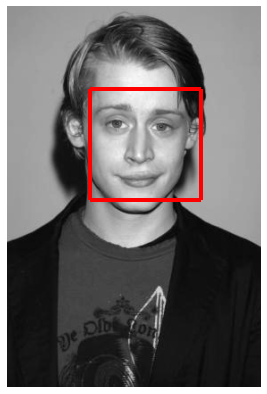

In [7]:
from menpodetect import load_dlib_frontal_face_detector

# Load detector
detect = load_dlib_frontal_face_detector()

# Detect
bboxes = detect(image)
print("{} detected faces.".format(len(bboxes)))

# View
if len(bboxes) > 0:
    image.view_landmarks(group='dlib_0', line_colour='red',
                         render_markers=False, line_width=4);

In [8]:
# initial bbox
initial_bbox = bboxes[0]

# fit image
result = fitter.fit_from_bb(image, initial_bbox, max_iters=[15, 5],
                            gt_shape=image.landmarks['PTS'].lms)

# print result
print(result)

/home/iris/anaconda3/envs/face-recognition/lib/python3.6/site-packages/menpo/shape/pointcloud.py:288: MenpoDeprecationWarning: The .lms property is deprecated. LandmarkGroups are now shapes themselves - so you can use them directly anywhere you previously used .lms.Simply remove ".lms" from your code and things will work as expected (and this warning will go away)
  MenpoDeprecationWarning,
Fitting result of 68 landmark points.
Initial error: 0.1643
Reconstructed initial error: 0.1643
Final error: 0.0189


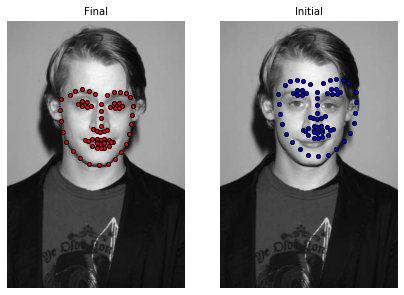

In [9]:
result.view(render_initial_shape=True)

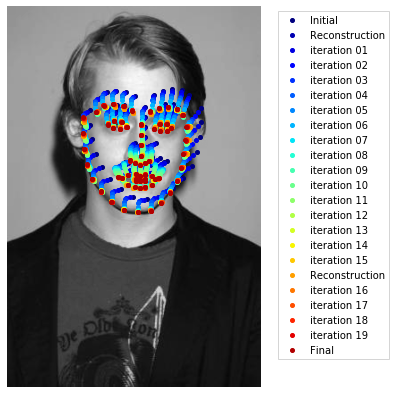

In [10]:
result.view_iterations()

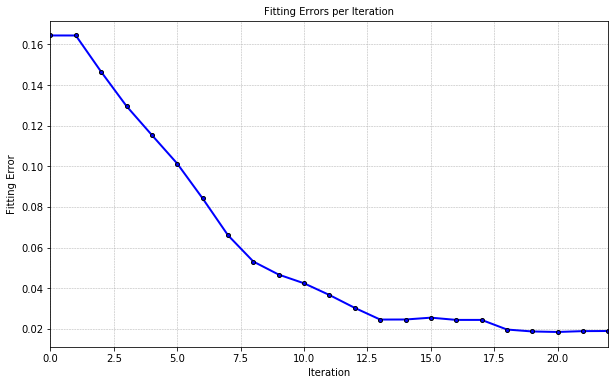

In [11]:
result.plot_errors()

Fitting result of 68 landmark points.
Initial error: 0.1886
Reconstructed initial error: 0.1885
Final error: 0.0228


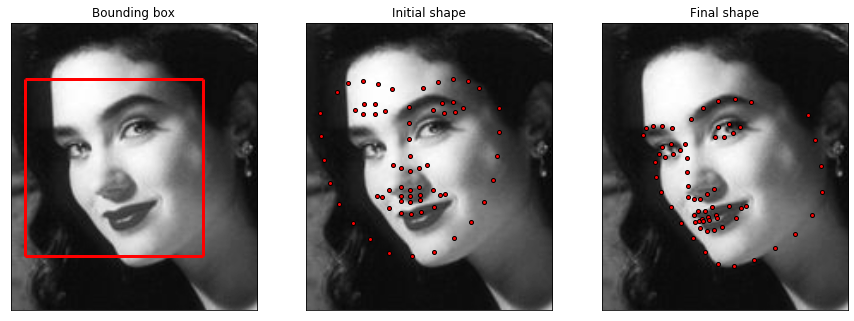

In [12]:
import matplotlib.pyplot as plt

# Load and convert to grayscale
image = mio.import_image(path_to_lfpw / 'image_0152.png')
image = image.as_greyscale()

# Detect face
bboxes = detect(image)

# Crop the image for better visualization of the result
image = image.crop_to_landmarks_proportion(0.3, group='dlib_0')
bboxes[0] = image.landmarks['dlib_0'].lms

if len(bboxes) > 0:
    # Fit AAM
    result = fitter.fit_from_bb(image, bboxes[0], max_iters=[15, 5],
                                gt_shape=image.landmarks['PTS'].lms)
    print(result)

    # Visualize
    plt.subplot(131);
    image.view()
    bboxes[0].view(line_width=3, render_markers=False)
    plt.gca().set_title('Bounding box')

    plt.subplot(132)
    image.view()
    result.initial_shape.view(marker_size=4)
    plt.gca().set_title('Initial shape')

    plt.subplot(133)
    image.view()
    result.final_shape.view(marker_size=4, figure_size=(15, 13))
    plt.gca().set_title('Final shape')